In [1]:
import pandas as pd
import numpy as np

import fastf1 as ff1

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colormaps
from matplotlib.collections import LineCollection
import fastf1.plotting


# Load FastF1's dark color scheme
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, 
                          misc_mpl_mods=False,
                          color_scheme='fastf1')

/Users/noviechiuman/miniconda3/envs/f1_streamlit/lib/python3.13/site-packages/fastf1/plotting/_plotting.py:57: FutureWarning: The `misc_mpl_mods` argument was dropped from `.setup_mpl()` in version 3.6.0 and has no effect anymore. It will be removed in a future version of FastF1.
  warnings.warn(


In [2]:
fastf1.Cache.enable_cache("~/Desktop/fast_f1/Caches/fastf1")

In [3]:
fastf1.get_event_schedule(2025)["Location"].unique()

array(['Sakhir', 'Melbourne', 'Shanghai', 'Suzuka', 'Jeddah', 'Miami',
       'Imola', 'Monaco', 'Barcelona', 'Montréal', 'Spielberg',
       'Silverstone', 'Spa-Francorchamps', 'Budapest', 'Zandvoort',
       'Monza', 'Baku', 'Marina Bay', 'Austin', 'Mexico City',
       'São Paulo', 'Las Vegas', 'Lusail', 'Yas Island'], dtype=object)

In [4]:
session = fastf1.get_session(2025, "Monaco", "Q")
session.load(telemetry=True, laps=True, weather=False)

core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '16', '81', '44', '1', '6', '14', '31', '30', '23', '55', '22', '27', '63', '12', '5', '87', '10', '18', '43']


In [5]:
fastest_lap = session.laps.pick_fastest()
fastest_lap

Time                      0 days 01:30:05.924000
Driver                                       NOR
DriverNumber                                   4
LapTime                   0 days 00:01:09.954000
LapNumber                                   26.0
Stint                                        6.0
PitOutTime                                   NaT
PitInTime                                    NaT
Sector1Time               0 days 00:00:18.216000
Sector2Time               0 days 00:00:33.254000
Sector3Time               0 days 00:00:18.484000
Sector1SessionTime        0 days 01:29:14.186000
Sector2SessionTime        0 days 01:29:47.440000
Sector3SessionTime        0 days 01:30:05.924000
SpeedI1                                    225.0
SpeedI2                                    215.0
SpeedFL                                    271.0
SpeedST                                    279.0
IsPersonalBest                              True
Compound                                    SOFT
TyreLife            

In [6]:
fastest_lap["Driver"]

'NOR'

In [7]:
fastest_lap["LapTime"]

Timedelta('0 days 00:01:09.954000')

In [8]:
leclerc_lap = session.laps.pick_drivers("LEC").pick_fastest()
leclerc_lap["LapTime"]

Timedelta('0 days 00:01:10.063000')

In [9]:
leclerc_lap["LapTime(s)"] = leclerc_lap["LapTime"].total_seconds()
leclerc_lap["LapTime(s)"]

/var/folders/r9/hplfpkd55xd25g8thjwryplr0000gn/T/ipykernel_1274/625387007.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leclerc_lap["LapTime(s)"] = leclerc_lap["LapTime"].total_seconds()
/var/folders/r9/hplfpkd55xd25g8thjwryplr0000gn/T/ipykernel_1274/625387007.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leclerc_lap["LapTime(s)"] = leclerc_lap["LapTime"].total_seconds()


70.063

In [10]:
p1_driver_laps_telemetry = session.laps.pick_drivers("NOR").pick_fastest()

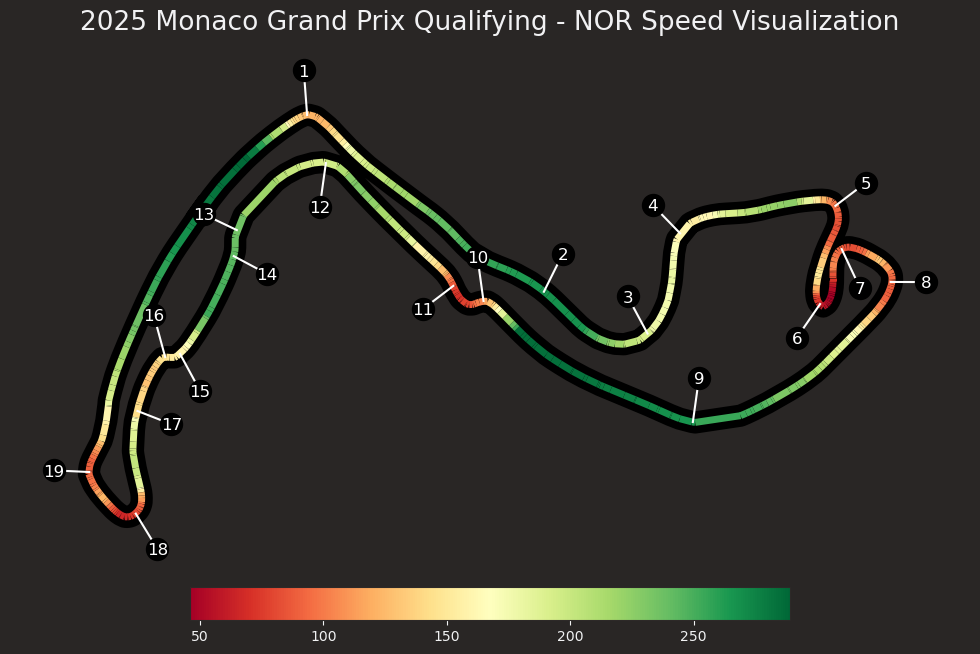

In [11]:
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

# Get telemetry data
x = p1_driver_laps_telemetry.telemetry['X']              # values for x-axis
y = p1_driver_laps_telemetry.telemetry['Y']              # values for y-axis
color = p1_driver_laps_telemetry.telemetry['Speed']      # value to base color gradient on

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

colormap = mpl.cm.RdYlGn

# Get circuit info for corners
circuit_info = session.get_circuit_info()

# Convert the rotation angle from degrees to radian.
track_angle = circuit_info.rotation / 180 * np.pi

# Rotate the track segments
rotated_segments = rotate(segments.reshape(-1, 2), angle=track_angle).reshape(-1, 2, 2)

# We create a plot with title and adjust some setting to make it look good.
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(12, 6.75))

# Adjust margins and turn of axis
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
ax.axis('off')

# Create background track line (rotated)
rotated_xy = rotate(np.array([x, y]).T, angle=track_angle)
ax.plot(rotated_xy[:, 0], rotated_xy[:, 1], 
        color='black', linestyle='-', linewidth=16, zorder=0)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(color.min(), color.max())
lc = LineCollection(rotated_segments, cmap=colormap, norm=norm,
                    linestyle='-', linewidth=5)

# Set the values used for colormapping
lc.set_array(color)

# Merge all line segments together
line = ax.add_collection(lc)

# Add corner annotations
offset_vector = [500, 0]

# Iterate over all corners.
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=track_angle)

    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle)

    # Draw a circle next to the track.
    ax.scatter(text_x, text_y, color='black', s=250, zorder=10)

    # Draw a line from the track to this circle.
    ax.plot([track_x, text_x], [track_y, text_y], color='white', zorder=9)

    # Finally, print the corner number inside the circle.
    ax.text(text_x, text_y, txt,
            color='white',
            va='center_baseline', ha='center', size='large', zorder=11)

# Finally, we create a color bar as a legend.
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
normlegend = mpl.colors.Normalize(vmin=color.min(), vmax=color.max())
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=colormap,
                                   orientation="horizontal")

ax.set_title('2025 Monaco Grand Prix Qualifying - NOR Speed Visualization')

# Show the plot
plt.show()

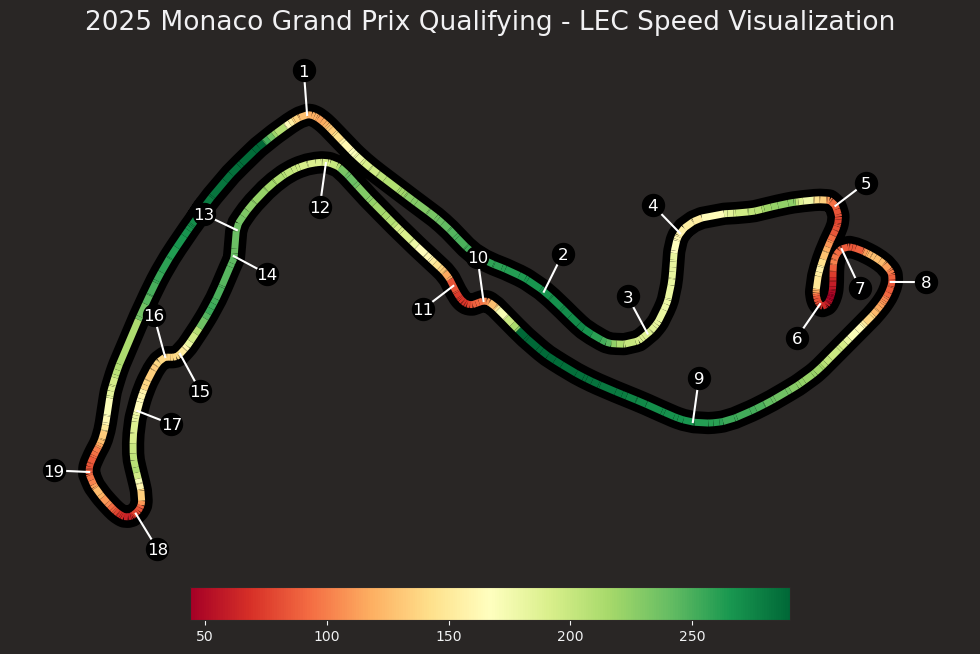

In [12]:
p2_driver_laps_telemetry = session.laps.pick_drivers("LEC").pick_fastest()

# Get telemetry data
x = p2_driver_laps_telemetry.telemetry['X']              # values for x-axis
y = p2_driver_laps_telemetry.telemetry['Y']              # values for y-axis
color = p2_driver_laps_telemetry.telemetry['Speed']      # value to base color gradient on

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

colormap = mpl.cm.RdYlGn

# Get circuit info for corners
circuit_info = session.get_circuit_info()

# Convert the rotation angle from degrees to radian.
track_angle = circuit_info.rotation / 180 * np.pi

# Rotate the track segments
rotated_segments = rotate(segments.reshape(-1, 2), angle=track_angle).reshape(-1, 2, 2)

# We create a plot with title and adjust some setting to make it look good.
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(12, 6.75))

# Adjust margins and turn of axis
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
ax.axis('off')

# Create background track line (rotated)
rotated_xy = rotate(np.array([x, y]).T, angle=track_angle)
ax.plot(rotated_xy[:, 0], rotated_xy[:, 1], 
        color='black', linestyle='-', linewidth=16, zorder=0)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(color.min(), color.max())
lc = LineCollection(rotated_segments, cmap=colormap, norm=norm,
                    linestyle='-', linewidth=5)

# Set the values used for colormapping
lc.set_array(color)

# Merge all line segments together
line = ax.add_collection(lc)

# Add corner annotations
offset_vector = [500, 0]

# Iterate over all corners.
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=track_angle)

    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle)

    # Draw a circle next to the track.
    ax.scatter(text_x, text_y, color='black', s=250, zorder=10)

    # Draw a line from the track to this circle.
    ax.plot([track_x, text_x], [track_y, text_y], color='white', zorder=9)

    # Finally, print the corner number inside the circle.
    ax.text(text_x, text_y, txt,
            color='white',
            va='center_baseline', ha='center', size='large', zorder=11)

# Finally, we create a color bar as a legend.
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
normlegend = mpl.colors.Normalize(vmin=color.min(), vmax=color.max())
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=colormap,
                                   orientation="horizontal")

ax.set_title('2025 Monaco Grand Prix Qualifying - LEC Speed Visualization')

# Show the plot
plt.show()

req            INFO 	Using cached data for driver_info


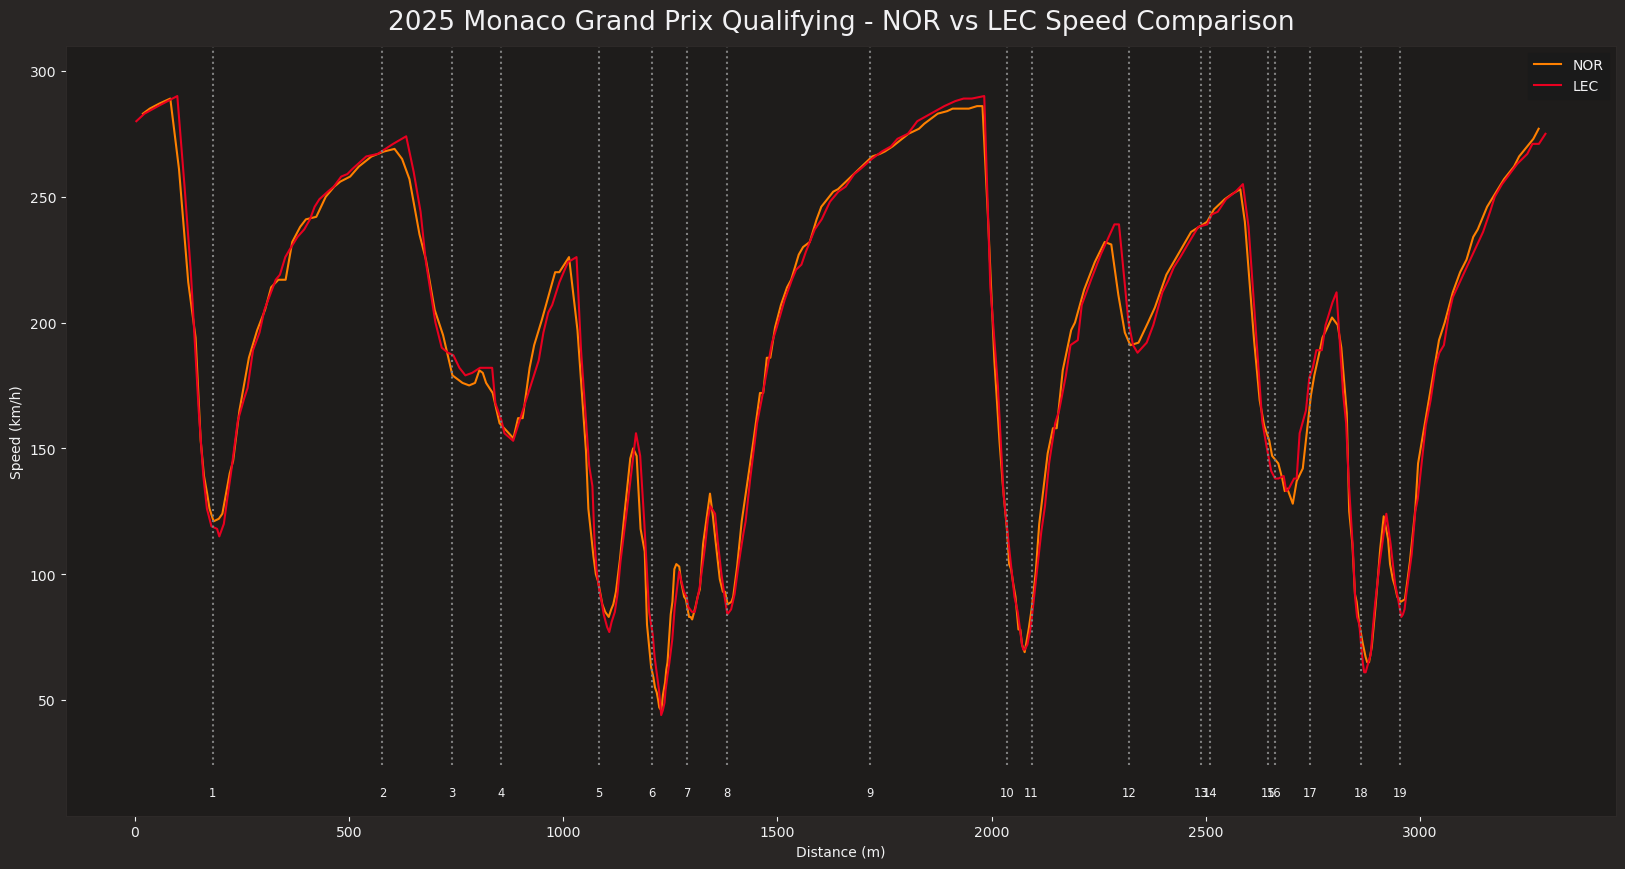

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))

for driver in ('NOR', 'LEC'):
    telemetry = session.laps.pick_drivers(driver).pick_fastest()
    car_data = telemetry.get_car_data().add_distance()

    style = fastf1.plotting.get_driver_style(identifier=driver,
                                             style=['color', 'linestyle'],
                                             session=session)
    
    ax.plot(car_data['Distance'], 
            car_data['Speed'],
            **style, 
            label=driver)

# Draw vertical dotted lines at each corner that range from slightly below the
# minimum speed to slightly above the maximum speed.
v_min = car_data['Speed'].min()
v_max = car_data['Speed'].max()
ax.vlines(x=circuit_info.corners['Distance'], 
            ymin=v_min-20, 
            ymax=v_max+20,
            linestyles='dotted', 
            colors='grey')

# Plot the corner number just below each vertical line.
# For corners that are very close together, the text may overlap. A more
# complicated approach would be necessary to reliably prevent this.
for _, corner in circuit_info.corners.iterrows():
    txt = f"{corner['Number']}{corner['Letter']}"
    ax.text(corner['Distance'], 
            v_min-30, txt,
            va='center_baseline', 
            ha='center', 
            size='small')

ax.set_xlabel('Distance (m)')
ax.set_ylabel('Speed (km/h)')
ax.set_title('2025 Monaco Grand Prix Qualifying - NOR vs LEC Speed Comparison')
ax.legend()

# Manually adjust the y-axis limits to include the corner numbers, because
# Matplotlib does not automatically account for text that was manually added.
ax.set_ylim([v_min - 40, v_max + 20])
    
plt.show()

/Users/noviechiuman/miniconda3/envs/f1_streamlit/lib/python3.13/site-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/noviechiuman/miniconda3/envs/f1_streamlit/lib/python3.13/site-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


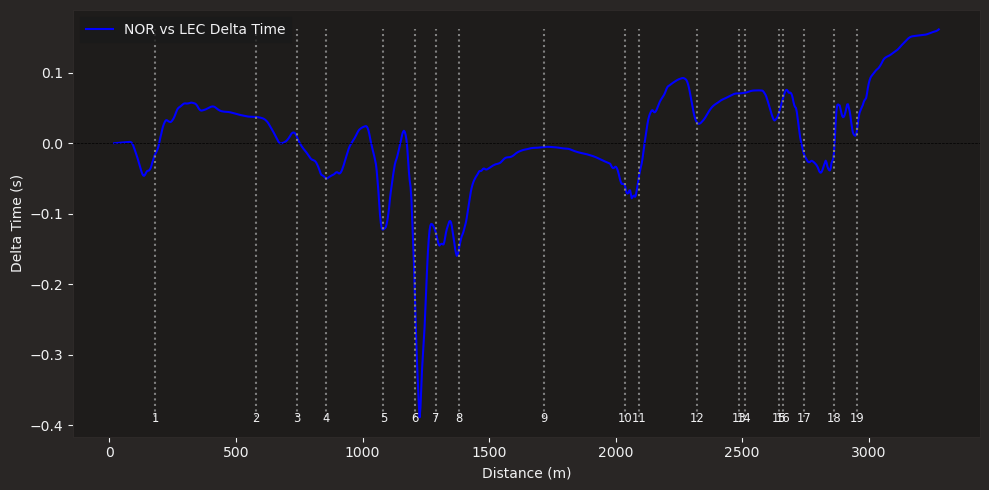

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

# Get telemetry for both drivers
telemetry_nor = session.laps.pick_driver('NOR').pick_fastest().get_car_data().add_distance()
telemetry_lec = session.laps.pick_driver('LEC').pick_fastest().get_car_data().add_distance()

# Interpolate to align data points by distance
min_dist = max(telemetry_nor['Distance'].min(), telemetry_lec['Distance'].min())
max_dist = min(telemetry_nor['Distance'].max(), telemetry_lec['Distance'].max())

ref_dist = np.linspace(min_dist, max_dist, num=1000)  # Common distance reference

# Interpolate speed for both drivers
speed_nor = np.interp(ref_dist, telemetry_nor['Distance'], telemetry_nor['Speed'])
speed_lec = np.interp(ref_dist, telemetry_lec['Distance'], telemetry_lec['Speed'])

# Calculate delta time (cumulative)
delta_time = np.cumsum((1 / speed_lec - 1 / speed_nor) * np.gradient(ref_dist) * 3.6)

ax.plot(ref_dist, delta_time, color='blue', label='NOR vs LEC Delta Time')
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)  # Zero reference
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Delta Time (s)')
ax.legend()

# Draw vertical dotted lines at each corner that range from slightly below the
# minimum speed to slightly above the maximum speed.
v_min = delta_time.min()
v_max = delta_time.max()
ax.vlines(x=circuit_info.corners['Distance'], 
            ymin=v_min, 
            ymax=v_max,
            linestyles='dotted', 
            colors='grey')

# Plot the corner number just below each vertical line.
# For corners that are very close together, the text may overlap. A more
# complicated approach would be necessary to reliably prevent this.
for _, corner in circuit_info.corners.iterrows():
    txt = f"{corner['Number']}{corner['Letter']}"
    ax.text(corner['Distance'], 
            v_min, txt,
            va='center_baseline', 
            ha='center', 
            size='small')

plt.tight_layout()
plt.show()